In [1]:
import holoocean
import numpy as np
import json
import math
import sys
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import operator

from IPython.display import display
from IPython.display import clear_output
import IPython

import plotly.io as pio

In [2]:
with open("./config_2.json", 'r') as f:
    cfg = json.load(f)

In [3]:
config = cfg['agents'][0]['sensors'][-1]["configuration"]
azi = config["Azimuth"]
ele = config["Elevation"]
minR = config["RangeMin"]
maxR = config['RangeMax']
binsR = config["RangeBins"]
binsA = config["AzimuthBins"]

In [4]:
phi = np.linspace(0, ele, binsR)*np.pi/180

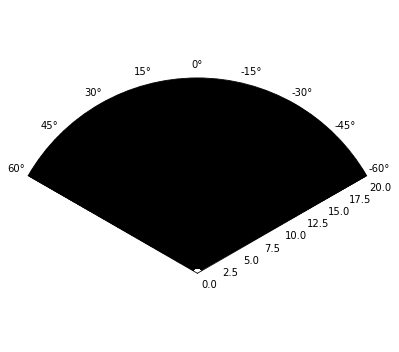

In [5]:
%matplotlib inline
plt.ion()
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,5))
ax.set_theta_zero_location("N")
ax.set_thetamin(-azi/2)
ax.set_thetamax(azi/2)

theta = np.linspace(-azi/2, azi/2, binsA)*np.pi/180
r = np.linspace(minR, maxR, binsR)
T, R = np.meshgrid(theta, r)
P,_ = np.meshgrid(phi, r)
z = np.zeros_like(T)

plt.grid(False)
plot = ax.pcolormesh(T, R, z, cmap='gray', shading='auto', vmin=0, vmax=1)
plt.tight_layout()
fig.set_facecolor("w")
fig.canvas.flush_events()

In [6]:
env = holoocean.make(scenario_cfg=cfg)

In [7]:
action = np.zeros(8)
action[0:4] -= 65

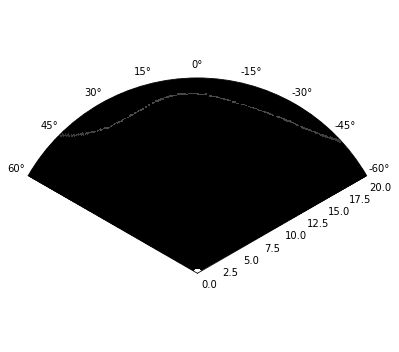

200

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

array([-16.97163], dtype=float32)

In [8]:
%matplotlib inline
states = env.tick()
env_map = []
for i in range(8):
    env.act('auv0', action)
    states = env.tick(num_ticks=20)
    clear_output()
    if 'ProfilingSonar' in states:
            s = states['ProfilingSonar']
            plot.set_array(s.ravel())
            fig.canvas.draw()
            fig.canvas.flush_events()
            display(fig)
    sonar = states["ProfilingSonar"]
    display(len(sonar))
    display(states["ProfilingSonar"])
    display(states["DepthSensor"])
#    display(action)

In [9]:
def get_coordinates(r, theta, phi, j):
#    return r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi), - r * np.cos(theta)
    return 0, r * np.sin(theta), -r * np.cos(theta) 

In [10]:
def get_coordinates_from_sonar_data(sonar_data, robot_coordinates, R=R, T=T, P=P):
    result = []
    for index_1, i in enumerate(sonar_data):
        if i.any():
            # array has at least one value other than zero
            for index_2, j in enumerate(i):
                if j == 0.: continue
                coords = get_coordinates(R[index_1][index_2], T[index_1][index_2], -1, j)
                result.append(tuple(map(operator.add, coords, robot_coordinates)))
    return result


In [11]:
action = np.zeros(8)
action[4:8] += 200

states = env.tick()
env_map = []
surface = [] 

In [12]:
for i in range(16*15):
    env.act('auv0', action)
    states = env.tick()
    clear_output()
    if 'ProfilingSonar' in states:
            s = states['ProfilingSonar']
            coords = get_coordinates_from_sonar_data(s, (states["PoseSensor"][0][3], states["PoseSensor"][1][3], states["PoseSensor"][2][3]))
            surface += coords
    

In [13]:
print(len(surface))

89467


In [14]:
with open("point_cloud.xyz", "w") as file:
    for x,y,z in surface:
        file.write("%f %f %f\n" % (x,y,z))

In [15]:
xxx,yyy,zzz = zip(*surface)

In [16]:
fig = go.Figure(data=[go.Scatter3d(x=xxx, y=yyy, z=zzz,
                                   mode='markers',
                                   marker=dict(
                                       size=2,
                                       color=zzz,
                                       colorscale='blackbody'
                                   ))]
               )

In [17]:
pio.renderers.default = ""

In [18]:
#fig.update_layout(
#    autosize=False,
#    width=1920, height=1080
#)

In [19]:
fig.write_html("environment_scatter.html")

In [20]:
# currently working
# surface plot wip. need to generalize data (z values need to be a 2d list (axis are x and y coords, 
# cell is the depth). x and y are the axis of the plot (e.g. x equally distributed values from 0 to 100
# if the agent travels from x = 0 to 100)

In [21]:
min_x, max_x = min(xxx), max(xxx)
min_y, max_y = min(yyy), max(yyy)
max_z = max(zzz)

In [22]:
surface_dist_between_x_y = 0.15

In [23]:
surface_x_count = int((max_x - min_x)/surface_dist_between_x_y)
surface_y_count = int((max_y - min_y)/surface_dist_between_x_y)

In [24]:
xxx_surface, yyy_surface = np.linspace(min_x, max_x, surface_x_count), np.linspace(min_y, max_y, surface_y_count)

In [25]:
zzz_surface = [None] * (surface_y_count + 1)
for i in range(surface_y_count + 1):
    zzz_surface[i] = [None] * (surface_x_count + 1)

In [26]:
def transform_point_to_surface(zzz_surface, x, y, z, x_min, y_min, x_max, y_max, x_count, y_count):
    i = int((y - y_min)/(y_max - y_min) * y_count)
    j = int((x - x_min)/(x_max - x_min) * x_count)

    if zzz_surface[i][j] is None:
        zzz_surface[i][j] = z

    return zzz_surface

In [27]:
for x,y,z in surface:
    zzz_surface = transform_point_to_surface(zzz_surface, x, y, z, min_x, min_y, max_x, max_y, surface_x_count, surface_y_count)

In [28]:
fig2_surface = go.Figure(data=[go.Surface(z=zzz_surface, x=xxx_surface, y=yyy_surface)])

In [29]:
fig2_surface.write_html("environment_surface.html")

/tmp/ipykernel_2502/386659789.py:15: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



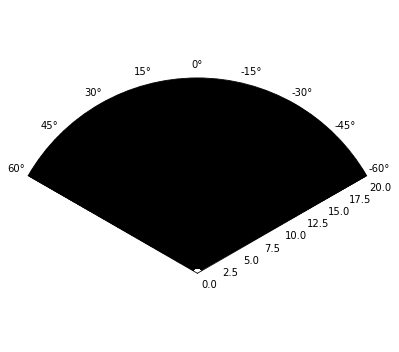

In [30]:
%matplotlib inline
plt.ion()
f_plt, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,5))
ax.set_theta_zero_location("N")
ax.set_thetamin(-azi/2)
ax.set_thetamax(azi/2)

theta = np.linspace(-azi/2, azi/2, binsA)*np.pi/180
r = np.linspace(minR, maxR, binsR)
T, R = np.meshgrid(theta, r)
P,_ = np.meshgrid(phi, r)
z = np.zeros_like(T)

plt.grid(True)
plot = ax.pcolormesh(T, R, z, cmap='gray', shading='auto', vmin=0, vmax=1)
plt.tight_layout()
f_plt.set_facecolor("w")
f_plt.canvas.flush_events()

In [31]:
s = states['ProfilingSonar']
s_copy = s.copy()

In [32]:
for ind1, x in enumerate(s_copy):
    for ind2, y in enumerate(x):
        if y != 0:
            s_copy[ind1][ind2]=1

In [33]:
plot.set_array(s_copy.ravel())
f_plt.canvas.draw()
f_plt.canvas.flush_events()

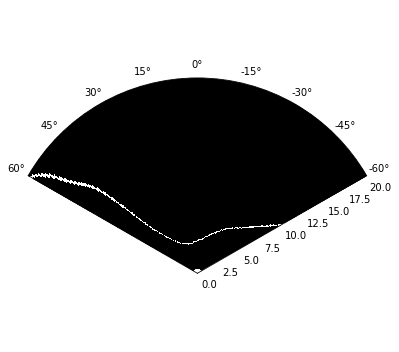

In [34]:
f_plt

In [35]:
s.shape

(200, 200)

In [36]:
s

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.2192426 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.22035895],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)